# Lab 4 Problem 1

Here we have a data file containing 

In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.
As with most data, there are 'features.' Your lab instructor has helpfully incorporated the meta-data into your data file.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [3]:
hf = h5py.File('gammaray_lab4.h5', 'r')
hf.keys();
data = np.array(hf.get('data'))
data[:,0];
hf.close()

1) Down load the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

The signal is discrete, periodic behavior (time and longitude dependance), no contamination in the data(?) -> most likely a Poisson with mu = 6;

In [107]:
start = 0
n = 500000
sub_data_time = data[0,start:n]
sub_data_solar_phase = data[1,start:n]
sub_data_longitude  = data[2,start:n]
sub_data_part_count = data[3,start:n]



In [101]:
# Scatter plots are not too useful so maybe delete this part for the final version?
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
# axes[0,0].plot(sub_data_time)
# axes[0,1].plot(sub_data_solar_phase)
# axes[1,0].plot(sub_data_longitude)
# axes[1,1].plot(sub_data_solar_phase,sub_data_part_count);

# axes[0,0].set_title("time, in gps seconds", fontsize=18);
# axes[0,1].set_title("Solar phase, deg", fontsize=18);
# axes[1,0].set_title("Earth longitude, deg", fontsize=18);
# axes[1,1].set_title("Particle counts", fontsize=18);

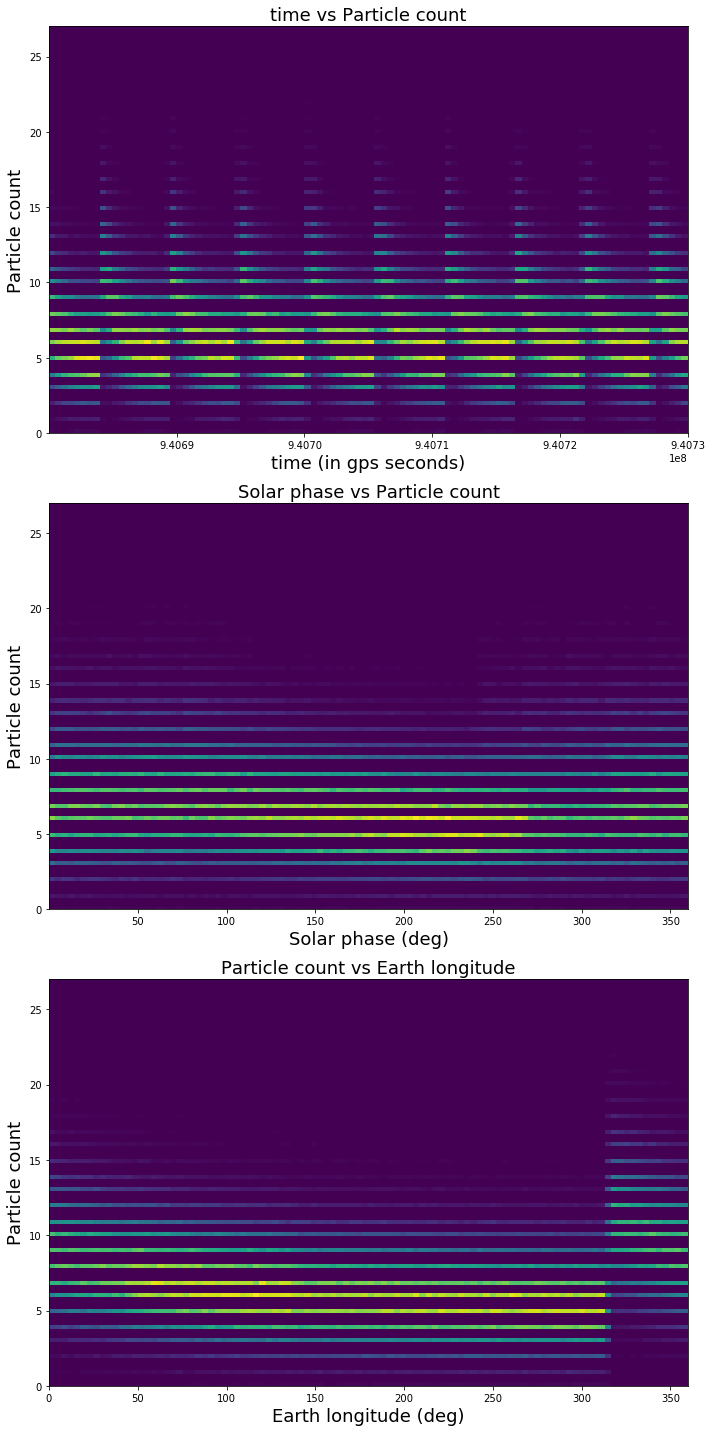

In [110]:
# histogram 
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,20))
axes[0].hist2d(sub_data_time,sub_data_part_count, bins = 100)
axes[0].set_xlabel('time (in gps seconds)', fontsize=18)
axes[0].set_ylabel('Particle count', fontsize=18)
axes[0].set_title("time vs Particle count", fontsize=18);

axes[1].hist2d(sub_data_solar_phase,sub_data_part_count, bins = 100)
axes[1].set_xlabel('Solar phase (deg)', fontsize=18)
axes[1].set_ylabel('Particle count', fontsize=18)
axes[1].set_title("Solar phase vs Particle count", fontsize=18);

axes[2].hist2d(sub_data_longitude,sub_data_part_count, bins = 100)
axes[2].set_xlabel('Earth longitude (deg)', fontsize=18)
axes[2].set_ylabel('Particle count', fontsize=18)
axes[2].set_title("Particle count vs Earth longitude", fontsize=18);

fig.tight_layout()

2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

The particle count has a short periodic behavior that depends on time and also on earth longitude.You can see in plot1 how the average number of count starts at the highest value at the beginning of the period and slowly decreases to a lower value and reaches its lowest value at the end of the period. Then it goes up to the same high average value at the beginning of a new period and repeats the pattern. You see this trend in the plot 3 as well.  So the particle count depend on both time and Earth longitude but it is independent of the solar phase.

3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

   - For this part, we have the right idea of using exponential decay and the poisson distribution but we are either multiplying these two nor are we convolving these two. The professor said we are "parametrizing". I think what he meant was the exponential should feed the value into a poisson distriubiton at that specific time X. So i think we using a for loop to feed our poisson distribution with a value we get from math.exp

In [150]:
start_time = np.min(data[0,0])
end_time = np.max(data[0,25920001-1])
duration_second = end_time - start_time
duration_minute = duration/60
duration_hours = duration/60/60
duration_days = hours/24
period = 90*60
num_period = duration_second/period

print('Start time = {:.0f}'.format(start_time))
print('Start time = {:.0f}'.format(end_time))
print('Duration in gps seconds = {:.0f} seconds'.format(duration_second))
print('Duration converted in minutes = {:.0f} minutes'.format(duration_minute))
print('Duration converted in hours = {:.0f} hours'.format(duration_hours))
print('Duration converted in hours = {:.0f} days'.format(duration_days))

print('Each period = {:.0f} seconds'.format(period))
print('Total number of period in this data = {:.0f} period'.format(num_period))

#plt.hist(sub_data_part_count,bins = 60);

Start time = 940680016
Start time = 943272016
Duration in gps seconds = 2592000 seconds
Duration converted in minutes = 43200 minutes
Duration converted in hours = 720 hours
Duration converted in hours = 30 days
Each period = 5400 seconds
Total number of period in this data = 480 period


4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

- Supposedly we found a distribution, how do we fit it to the data we have ? eyeballing it?

Optional: while this is simulated data, it is based on a real effect seen by low Earth orbit satellites. Can you identify the cause of the variable background and propose a physical model?

# Problem 2
In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

1) Dowload the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.


In [7]:
hf = h5py.File('images.h5', 'r')
hf.keys()


<KeysViewHDF5 ['image1', 'imagestack']>

In [8]:
imagestack = np.array(hf.get('imagestack'))
hf.close()

2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

- Here I plotted out all 10 images to see if there is anything I could detect with my eyes. If there is something like a supernova in the image I thought I might be able to see it in the picture but it was not possible.

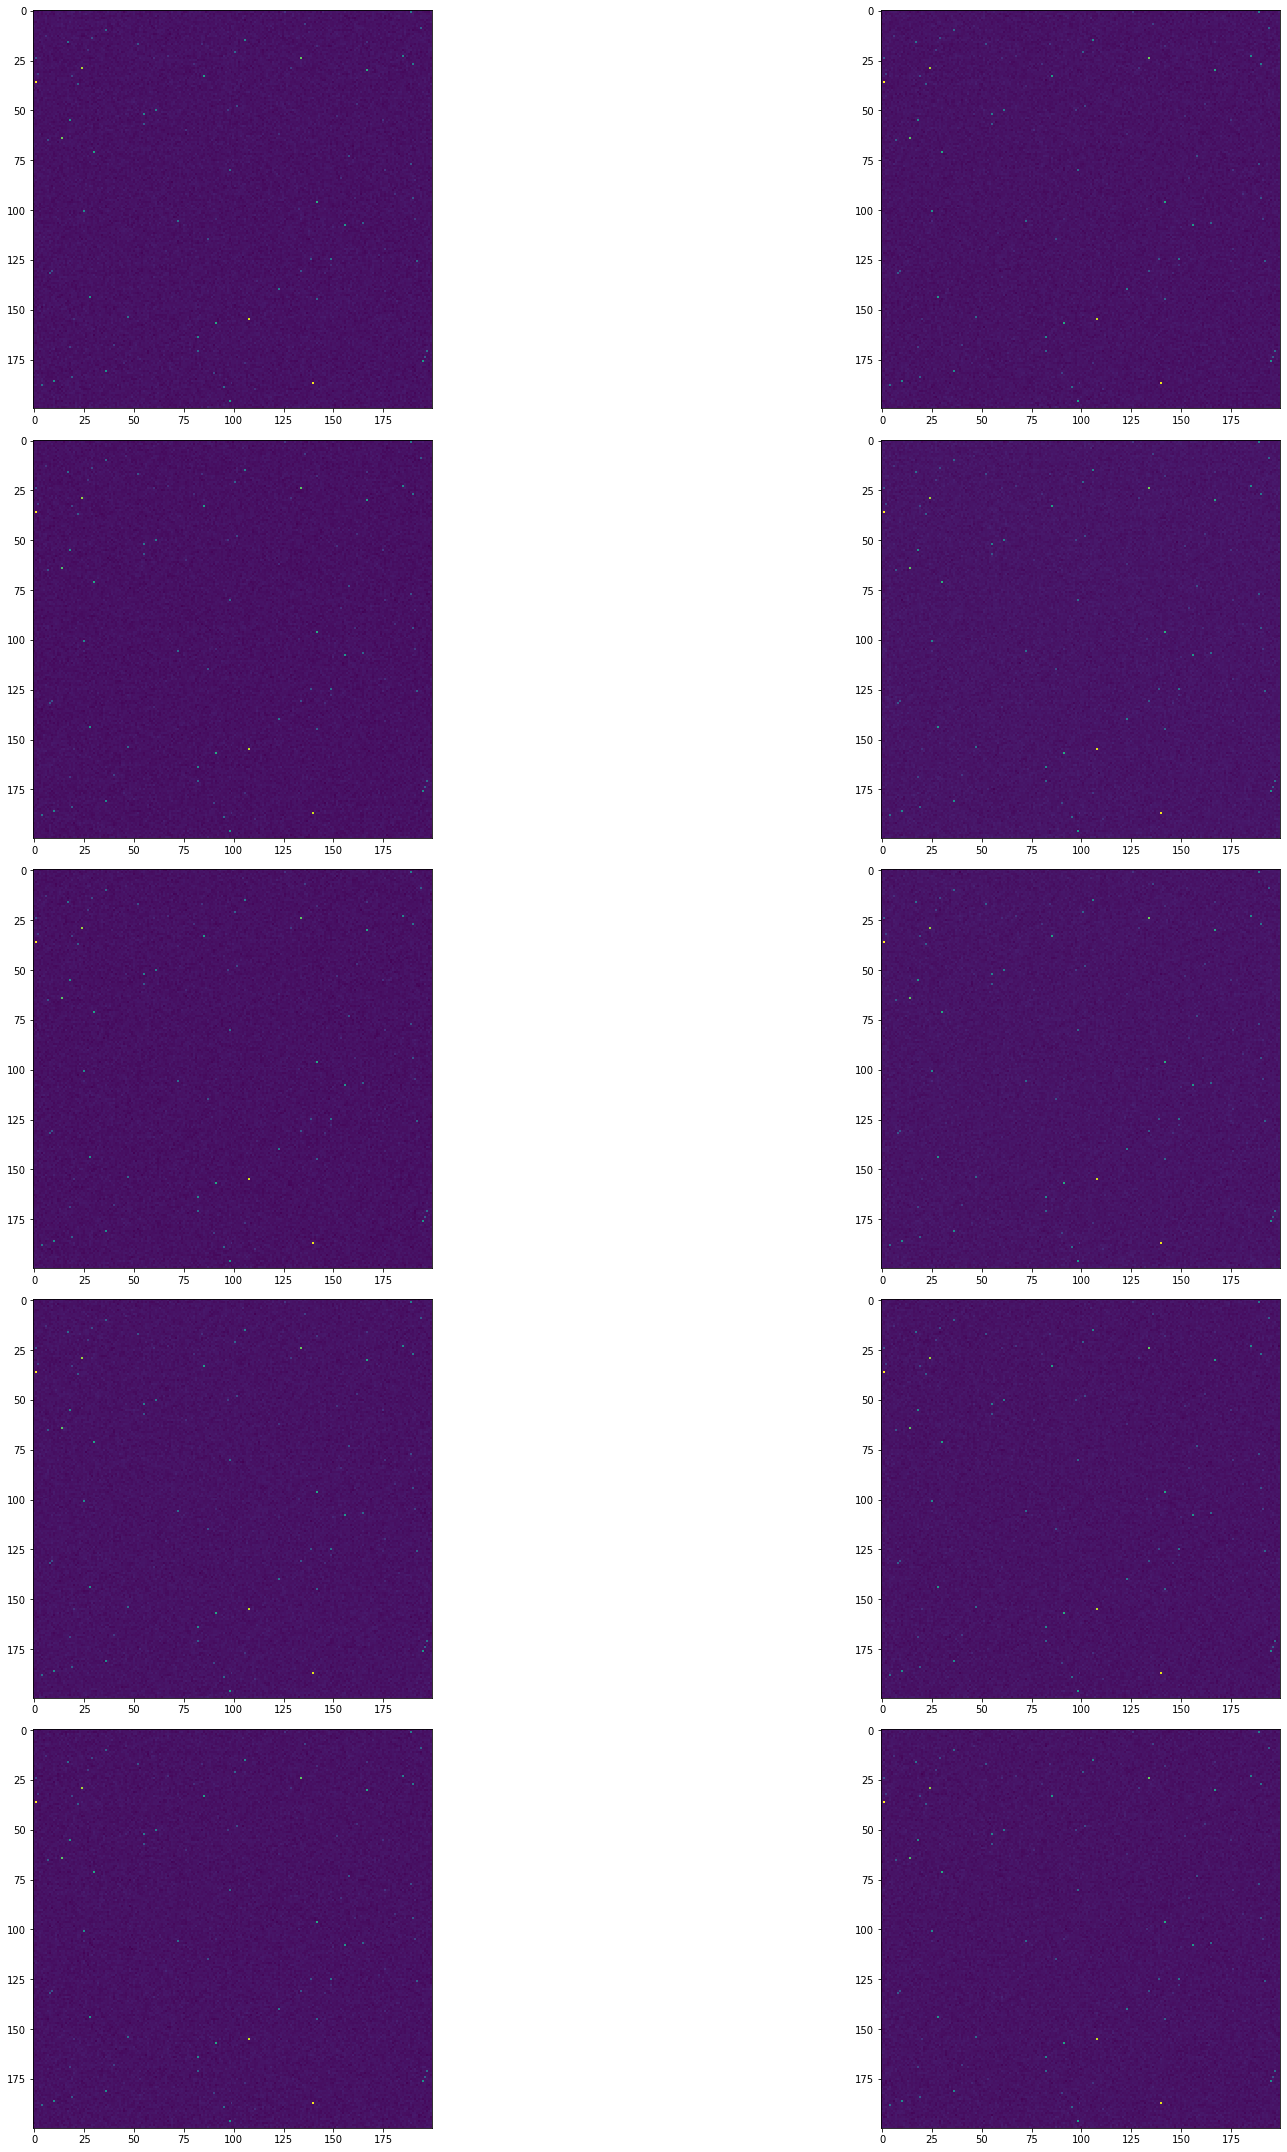

In [9]:
from PIL import Image

# in the array the x value = brighness, y value = signal brightness
#weighted_signal_brightness =

image1 = imagestack[:,:,0]
image2 = imagestack[:,:,1]
image3 = imagestack[:,:,2]
image4 = imagestack[:,:,3]
image5 = imagestack[:,:,4]
image6 = imagestack[:,:,5]
image7 = imagestack[:,:,6]
image8 = imagestack[:,:,7]
image9 = imagestack[:,:,8]
image10 = imagestack[:,:,9]


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(30, 30))
axes[0,0].imshow(image1)
axes[0,1].imshow(image2)
axes[1,0].imshow(image3)
axes[1,1].imshow(image4)
axes[2,0].imshow(image5)
axes[2,1].imshow(image6)
axes[3,0].imshow(image7)
axes[3,1].imshow(image8)
axes[4,0].imshow(image9)
axes[4,1].imshow(image10)
fig.tight_layout()

- Since it was not possible to detect anything with my naked eyes, I decided to plot an image of the difference in two images. I could create another image which is the average of the 10 images but this will also add more background data to each pixels so i decided to use the original image to take the difference.

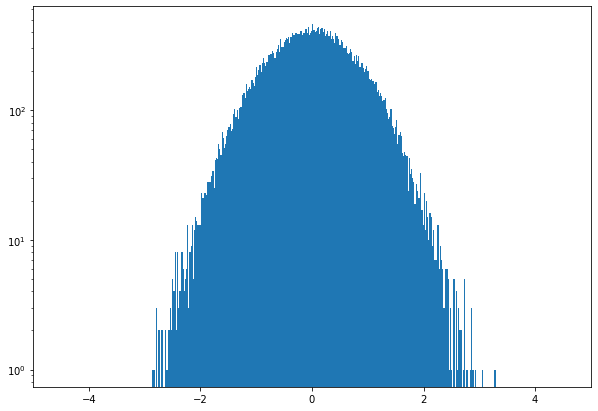

In [35]:
sub =  image3 - image1
plt.hist(np.ravel(sub), bins = 300);
plt.yscale('log')
plt.xlim(-5,5);

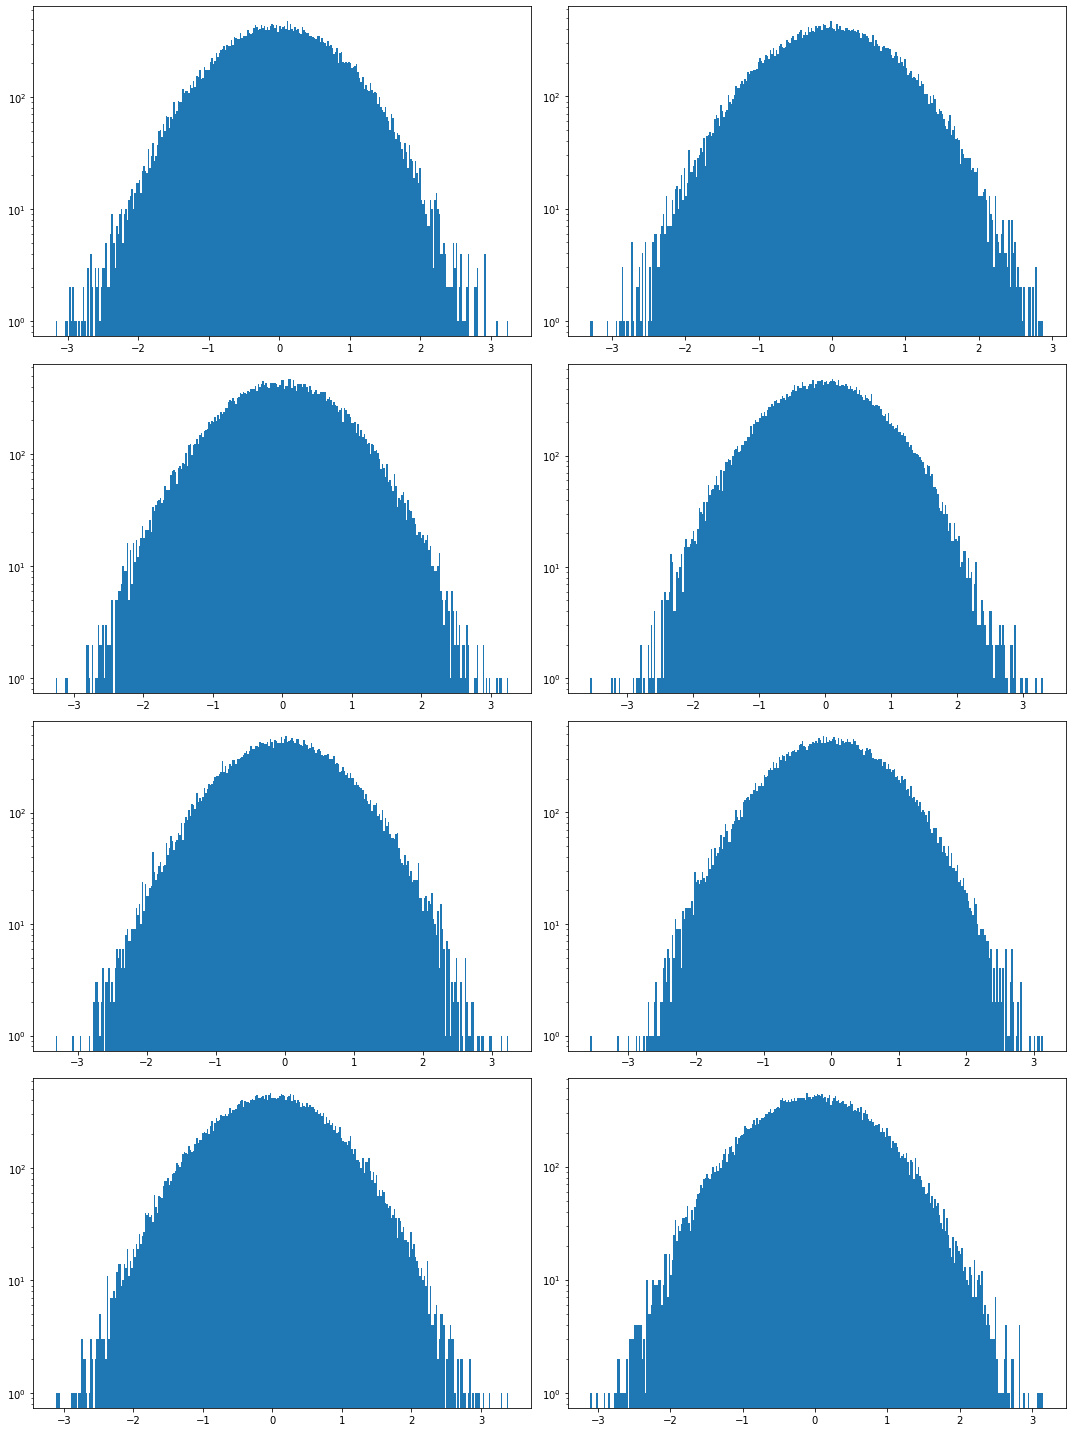

In [50]:
image_dff_12 = image1 - image2
image_dff_13 = image1 - image3
image_dff_14 = image1 - image4
image_dff_15 = image1 - image5
image_dff_16 = image1 - image6
image_dff_17 = image1 - image7
image_dff_18 = image1 - image8
image_dff_19 = image1 - image9

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

axes[0,0].hist(np.ravel(image_dff_12), bins = 300)
axes[0,0].set_yscale('log')
axes[0,1].hist(np.ravel(image_dff_13), bins = 300)
axes[0,1].set_yscale('log')
axes[1,0].hist(np.ravel(image_dff_14), bins = 300)
axes[1,0].set_yscale('log')
axes[1,1].hist(np.ravel(image_dff_15), bins = 300)
axes[1,1].set_yscale('log')
axes[2,0].hist(np.ravel(image_dff_16), bins = 300)
axes[2,0].set_yscale('log')
axes[2,1].hist(np.ravel(image_dff_17), bins = 300)
axes[2,1].set_yscale('log')
axes[3,0].hist(np.ravel(image_dff_18), bins = 300)
axes[3,0].set_yscale('log')
axes[3,1].hist(np.ravel(image_dff_19), bins = 300)
axes[3,1].set_yscale('log')
fig.tight_layout()

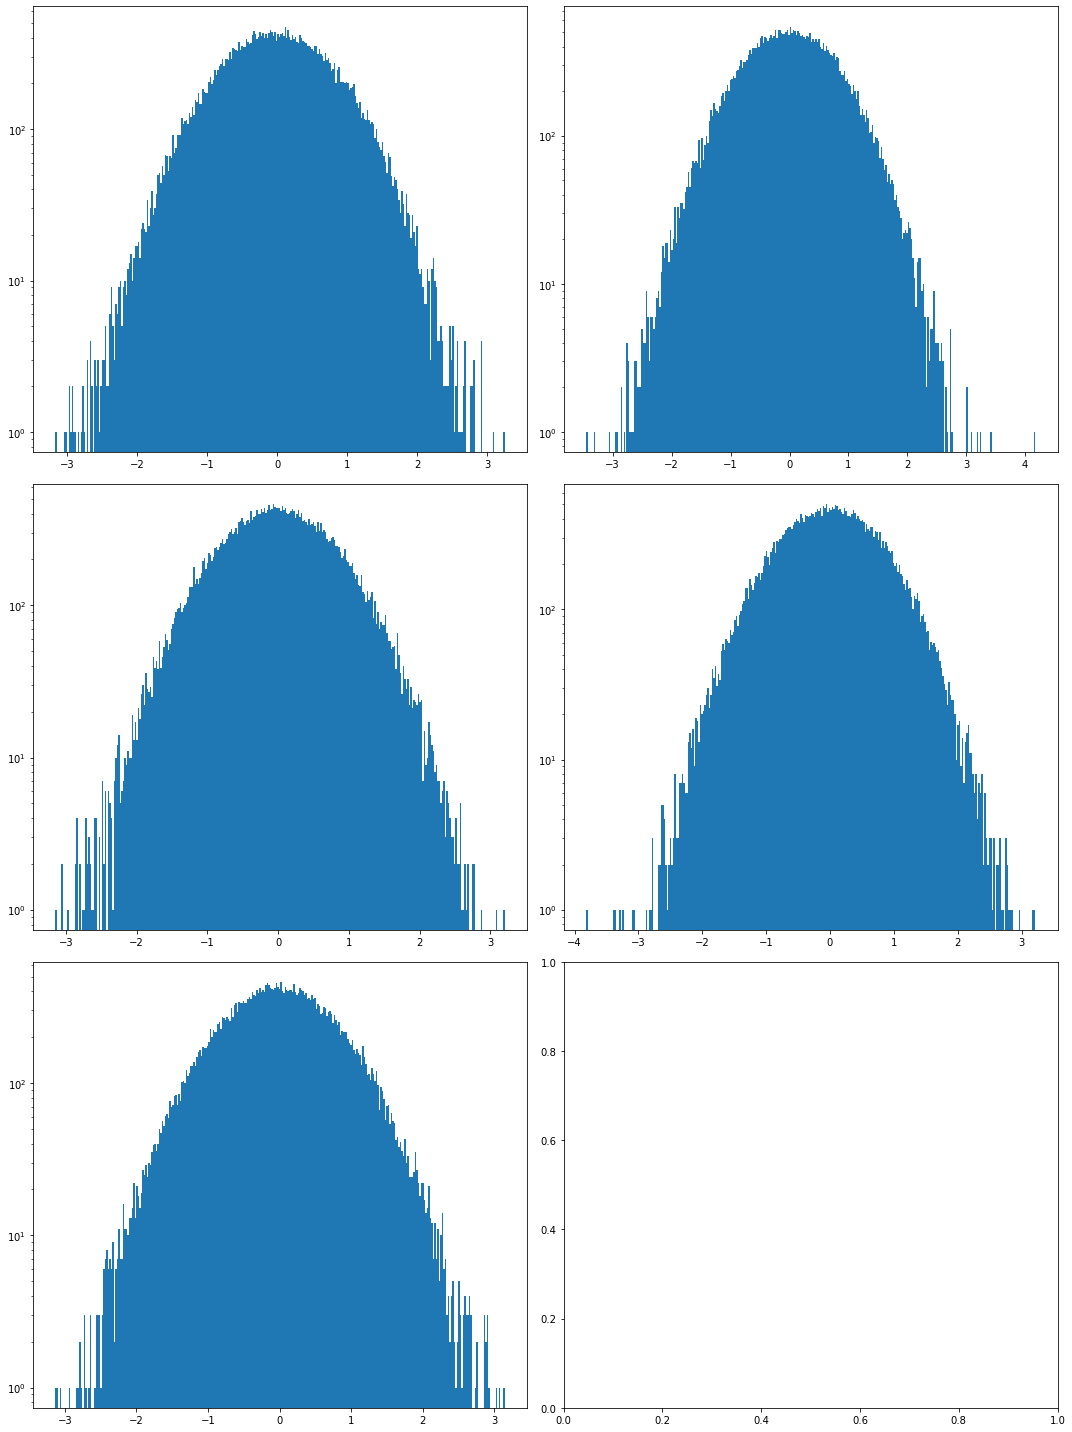

In [51]:
image_dff_12 = image1 - image2
image_dff_34 = image3 - image4
image_dff_56 = image5 - image6
image_dff_78 = image7 - image8
image_dff_910 = image9 - image10


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
axes[0,0].hist(np.ravel(image_dff_12), bins = 300)
axes[0,0].set_yscale('log')
axes[0,1].hist(np.ravel(image_dff_34), bins = 300)
axes[0,1].set_yscale('log')
axes[1,0].hist(np.ravel(image_dff_56), bins = 300)
axes[1,0].set_yscale('log')
axes[1,1].hist(np.ravel(image_dff_78), bins = 300)
axes[1,1].set_yscale('log')
axes[2,0].hist(np.ravel(image_dff_910), bins = 300)
axes[2,0].set_yscale('log')

fig.tight_layout()

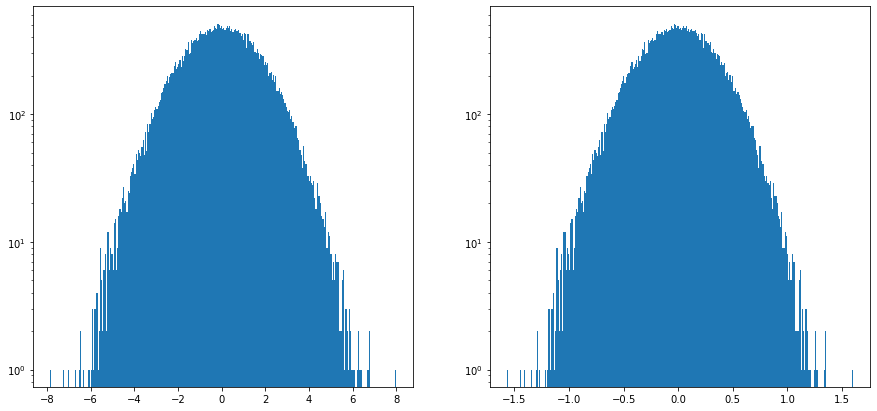

In [73]:
image_dff_12 = image1 - image2
image_dff_34 = image3 - image4
image_dff_56 = image5 - image6
image_dff_78 = image7 - image8
image_dff_910 = image9 - image10

sum_image = image_dff_12 + image_dff_34 + image_dff_56 + image_dff_78 + image_dff_910
ave_image = (image_dff_12 + image_dff_34 + image_dff_56 + image_dff_78 + image_dff_910)/5

#plt.hist(np.ravel(sum_image), bins = 300);
#plt.yscale('log');
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axes[0].hist(np.ravel(sum_image), bins = 300)
axes[0].set_yscale('log')
axes[1].hist(np.ravel(ave_image), bins = 300)
axes[1].set_yscale('log')


3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.

In [15]:
signal_strength = 15
prob = stats.rayleigh.cdf(signal_strength,loc = 0, scale = 1.5)
print('The % of data contained in this data set = {:.8%}'.format(prob))

The % of data contained in this data set = 100.00000000%


4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.